# NCAAM 2022 ANALYSIS
* https://kenpompy.readthedocs.io/en/latest/


# IMPORTS

In [ ]:
# LIBRARY IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as stats
import statistics

import requests
from bs4 import BeautifulSoup
import json
import time
import nltk
import re

from google.colab import drive


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#from tabulate import tabulate
#from difflib import get_close_matches
#from itertools import islice

print("\nIMPORT SUCCESS")


IMPORT SUCCESS


In [ ]:
drive.mount('drive')

Mounted at drive


# KENPOM

## DATA SCRAPE

In [ ]:
# KENPOM DATA SCRAPE

# Base url, and a lambda func to return url for a given year
base_url = 'http://kenpom.com/index.php'
url_year = lambda x: '%s?y=%s' % (base_url, str(x) if x != 2021 else base_url)

# Years on kenpom's site; scrape and set as list to be more dynamic?
years = range(2021, 2022)

# Create a method that parses a given year and spits out a raw dataframe
def import_raw_year(year):
    """
    Imports raw data from a kenpom year into a dataframe
    """
    f = requests.get(url_year(year))
    soup = BeautifulSoup(f.text, "lxml")
    table_html = soup.find_all('table', {'id': 'ratings-table'})

    # Weird issue w/ <thead> in the html
    # Prevents us from just using pd.read_html
    # Find all <thead> contents and replace/remove them
    # This allows us to easily put the table row data into a dataframe using pandas
    thead = table_html[0].find_all('thead')

    table = table_html[0]
    for x in thead:
        table = str(table).replace(str(x), '')

    kp_df = pd.read_html(table)[0]
    kp_df['year'] = year
    return kp_df
    
# Import all the years into a singular dataframe
kp_df = None
for x in years:
    kp_df = pd.concat( (kp_df, import_raw_year(x)), axis=0) if kp_df is not None else import_raw_year(2022)

# Column rename based off of original website
kp_df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Adj EM', 
             'AdjO', 'AdjO Rank', 'AdjD', 'AdjD Rank',
             'AdjT', 'AdjT Rank', 'Luck', 'Luck Rank', 
             'SOS Adj EM', 'SOS Adj EM Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Adj EM', 'NCSOS Adj EM Rank', 'Year']
             
# Lambda that returns true if given string is a number and a valid seed number (1-16)
valid_seed = lambda x: True if str(x).replace(' ', '').isdigit() \
                and int(x) > 0 and int(x) <= 16 else False

# Use lambda to parse out seed/team
kp_df['Seed'] = kp_df['Team'].apply(lambda x: x[-2:].replace(' ', '') \
                              if valid_seed(x[-2:]) else np.nan )

kp_df['Team'] = kp_df['Team'].apply(lambda x: x[:-2] if valid_seed(x[-2:]) else x)

# Split W-L column into Win / Loss
kp_df['Win'] = kp_df['W-L'].apply(lambda x: int(re.sub('-.*', '', x)) )
kp_df['Loss'] = kp_df['W-L'].apply(lambda x: int(re.sub('.*-', '', x)) )
kp_df.drop('W-L', inplace=True, axis=1)


# Reorder columns
kp_df=kp_df[[ 'Year', 'Rank', 'Team', 'Conference', 'Win', 'Loss', 'Seed','Adj EM', 
             'AdjO', 'AdjO Rank', 'AdjD', 'AdjD Rank',
             'AdjT', 'AdjT Rank', 'Luck', 'Luck Rank', 
             'SOS Adj EM', 'SOS Adj EM Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Adj EM', 'NCSOS Adj EM Rank']]

kp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               358 non-null    int64  
 1   Rank               358 non-null    int64  
 2   Team               358 non-null    object 
 3   Conference         358 non-null    object 
 4   Win                358 non-null    int64  
 5   Loss               358 non-null    int64  
 6   Seed               68 non-null     object 
 7   Adj EM             358 non-null    float64
 8   AdjO               358 non-null    float64
 9   AdjO Rank          358 non-null    int64  
 10  AdjD               358 non-null    float64
 11  AdjD Rank          358 non-null    int64  
 12  AdjT               358 non-null    float64
 13  AdjT Rank          358 non-null    int64  
 14  Luck               358 non-null    float64
 15  Luck Rank          358 non-null    int64  
 16  SOS Adj EM         358 non

## DATA EXPORT

In [ ]:
kp_df.to_csv('drive/My Drive/SPORTS/kenpom_pull_3-14-22.csv', index=False)
kp_df.to_excel('drive/My Drive/SPORTS/kenpom_pull_3-14-22.xlsx', index=False)

#Derive the id from the google drive shareable link.

##For the file at hand the link is as below
#URL = 'https://drive.google.com/file/d/1m0mAGzpeMR0W-BDL5BtKrs0HOZsPIAbX/view?usp=sharing'
#path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
#df = pd.read_pickle(path)
#df = pd.read_csv(path)


## DATA IMPORT

In [ ]:
#kenpom_2022 = pd.read_csv('drive/My Drive/SPORTS/kenpom_pull_3-14-22.csv')
kenpom_2022 = pd.read_excel('drive/My Drive/SPORTS/kenpom_pull_3-14-22.xlsx')

kenpom_2022 = kenpom_2022[kenpom_2022['Year'] == 2022]
kenpom_2022 = kenpom_2022.drop(columns=['Year', 'AdjO Rank', 'AdjD Rank', 'AdjT Rank','SOS OppO Rank', 'SOS OppD Rank', 'SOS Adj EM Rank', 'NCSOS Adj EM Rank', 'Luck Rank'])
mm_2022 = kenpom_2022[kenpom_2022['Seed'] >= 1]
mm_2022 = mm_2022.set_index('Team')
#print(kenpom_2022.info())
#print(kenpom_2022.head())

print(mm_2022.info())
print(mm_2022.head())

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, Gonzaga to Texas A&M Corpus Chris 
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          68 non-null     int64  
 1   Conference    68 non-null     object 
 2   Win           68 non-null     int64  
 3   Loss          68 non-null     int64  
 4   Seed          68 non-null     float64
 5   Adj EM        68 non-null     float64
 6   AdjO          68 non-null     float64
 7   AdjD          68 non-null     float64
 8   AdjT          68 non-null     float64
 9   Luck          68 non-null     float64
 10  SOS Adj EM    68 non-null     float64
 11  SOS OppO      68 non-null     float64
 12  SOS OppD      68 non-null     float64
 13  NCSOS Adj EM  68 non-null     float64
dtypes: float64(10), int64(3), object(1)
memory usage: 8.0+ KB
None
          Rank Conference  Win  Loss  Seed  Adj EM   AdjO  AdjD  AdjT   Luck  \
Team                                   

In [ ]:
kp_cols = kenpom_2022.columns
mm_cols = mm_2022.columns
kp_num_cols = kenpom_2022[['Rank', 'Win', 'Loss', 'Seed', 'Adj EM', 'AdjO', 'AdjD', 'AdjT', 'SOS Adj EM', 'SOS OppO', 'SOS OppD', 'NCSOS Adj EM']]
kp_cat_cols = kenpom_2022[['Team', 'Conference']]

#top50_2022 = kenpom_2022[(kenpom_2022['Rank'] <= 50)].drop(columns=['Year'])
#top100_2022 = kenpom_2022[(kenpom_2022['Rank'] <= 100)].drop(columns=['Year'])
#top150_2022 = kenpom_2022[(kenpom_2022['Rank'] <= 150)].drop(columns=['Year'])

In [ ]:
#print(kp_num_cols)
#kenpom_2022[:100]
print(mm_cols)
print('---------------------------------------------------------------------------------')
print(mm_2022)

Index(['Rank', 'Conference', 'Win', 'Loss', 'Seed', 'Adj EM', 'AdjO', 'AdjD',
       'AdjT', 'Luck', 'SOS Adj EM', 'SOS OppO', 'SOS OppD', 'NCSOS Adj EM'],
      dtype='object')
---------------------------------------------------------------------------------
                         Rank Conference  Win  Loss  Seed  Adj EM   AdjO  \
Team                                                                       
Gonzaga                     1        WCC   26     3   1.0   32.87  121.8   
Arizona                     2        P12   31     3   1.0   27.21  119.6   
Kentucky                    3        SEC   26     7   2.0   26.65  120.2   
Houston                     4       Amer   29     5   5.0   26.56  117.3   
Baylor                      5        B12   26     6   1.0   26.48  117.9   
...                       ...        ...  ...   ...   ...     ...    ...   
Norfolk St.               168       MEAC   24     6  16.0    0.19  102.4   
Wright St.                179       Horz   21    13  16.

In [ ]:
print(mm_2022.index)

Index(['Gonzaga', 'Arizona', 'Kentucky', 'Houston', 'Baylor', 'Kansas',
       'Tennessee', 'UCLA', 'Texas Tech', 'Auburn', 'Villanova', 'Duke',
       'Iowa', 'Purdue', 'Texas', 'Illinois', 'Saint Mary's', 'Connecticut',
       'LSU', 'Arkansas', 'San Francisco ', 'Virginia Tech ', 'San Diego St.',
       'Loyola Chicago ', 'Alabama', 'Murray St.', 'Memphis', 'Boise St.',
       'North Carolina', 'Ohio St.', 'Michigan ', 'Wisconsin', 'Colorado St.',
       'Indiana ', 'TCU', 'Michigan St.', 'Davidson ', 'Seton Hall', 'USC',
       'Iowa St. ', 'Marquette', 'UAB ', 'Providence', 'Notre Dame ',
       'Creighton', 'Vermont ', 'Miami FL ', 'Wyoming ', 'South Dakota St. ',
       'Chattanooga ', 'Rutgers ', 'New Mexico St. ', 'Richmond ',
       'Saint Peter's ', 'Colgate ', 'Montana St. ', 'Akron ', 'Longwood ',
       'Delaware ', 'Jacksonville St. ', 'Yale ', 'Cal St. Fullerton ',
       'Georgia St. ', 'Norfolk St. ', 'Wright St. ', 'Bryant ',
       'Texas Southern ', 'Texas A&M Corp

In [ ]:
# CORRELATION MATRIX
mm_2022.corr()

,Rank,Win,Loss,Seed,Adj EM,AdjO,AdjD,AdjT,Luck,SOS Adj EM,SOS OppO,SOS OppD,NCSOS Adj EM
Rank,1.000000,-0.350129,0.327365,0.844806,-0.950709,-0.766933,0.723385,0.061112,0.241299,-0.833938,-0.802880,0.810497,-0.130291
Win,-0.350129,1.000000,-0.872711,-0.416517,0.431148,0.509735,-0.142044,-0.004858,0.136246,-0.073942,-0.074784,0.066502,-0.042761
Loss,0.327365,-0.872711,1.000000,0.438472,-0.411780,-0.443883,0.185099,-0.007056,-0.295242,0.097298,0.142649,-0.041464,-0.052128
Seed,0.844806,-0.416517,0.438472,1.000000,-0.915210,-0.753648,0.678741,-0.079659,0.077289,-0.763154,-0.714880,0.762314,-0.053965
Adj EM,-0.950709,0.431148,-0.411780,-0.915210,1.000000,0.816118,-0.750246,0.037794,-0.284827,0.780030,0.736090,-0.773722,0.078603
AdjO,-0.766933,0.509735,-0.443883,-0.753648,0.816118,1.000000,-0.230239,0.083520,-0.212178,0.556744,0.556311,-0.521677,0.084298
AdjD,0.723385,-0.142044,0.185099,0.678741,-0.750246,-0.230239,1.000000,0.032137,0.238000,-0.676547,-0.602534,0.706582,-0.035943
AdjT,0.061112,-0.004858,-0.007056,-0.079659,0.037794,0.083520,0.032137,1.000000,-0.035105,-0.016807,-0.008753,0.022564,0.128746
Luck,0.241299,0.136246,-0.295242,0.077289,-0.284827,-0.212178,0.238000,-0.035105,1.000000,-0.143350,-0.163667,0.113160,0.038871
SOS Adj EM,-0.833938,-0.073942,0.097298,-0.763154,0.780030,0.556744,-0.676547,-0.016807,-0.143350,1.000000,0.967905,-0.965236,0.105912


## DATA VIZ

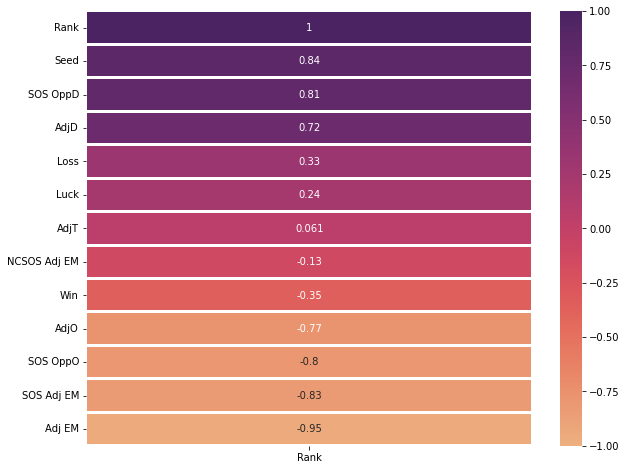

In [ ]:
# create correlation variables relative to rest of DataFrame
rank_corr = mm_2022.corr()[['Rank']].sort_values(by = 'Rank', ascending = False)
seed_corr = mm_2022.corr()[['Seed']].sort_values(by = 'Seed', ascending = False)

# create heatmap to visualize correlation variable
  # SUBPLOTS
plt.figure(figsize=(10,8))
sns.heatmap(rank_corr, annot = True, cmap = 'flare', vmin=-1, vmax=1, linecolor = 'white', linewidth = 2);
#sns.heatmap(seed_corr, annot = True, cmap = 'flare', vmin=-1, vmax=1, linecolor = 'white', linewidth = 2);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


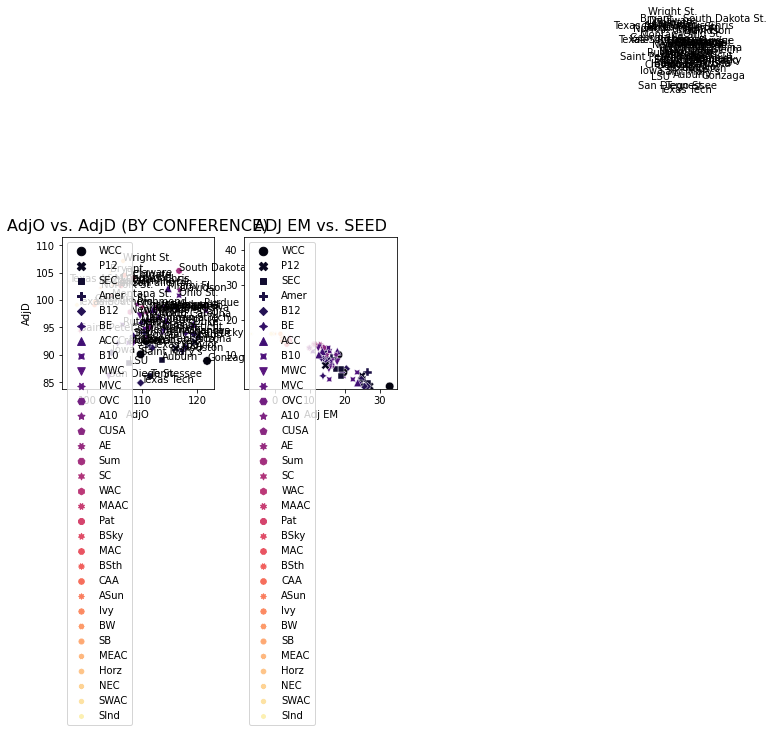

In [ ]:
# SCATTERPLOT - NET EM VS WINS

#f, (ax1) = plt.subplots(1, 1)

#plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=mm_2022, x='AdjO', y='AdjD', hue='Conference', style='Conference', size='Conference', palette='magma', markers=True)
plt.title('AdjO vs. AdjD (BY CONFERENCE)', fontsize=16)
#sns.set_title('AdjO vs. AdjD ')
#plt.xlabel('ADJ. OFFENSE', fontsize=16)
#plt.ylabel('ADJ. DEFENSE', fontsize=16)
plt.axis('square')
plt.legend(loc='best')

for i in mm_2022.index:
  plt.text(mm_2022.AdjO[mm_2022.index==i]+.01,mm_2022.AdjD[mm_2022.index==i]+.01,str(i), color='black')

plt.subplot(1, 2, 2)
sns.scatterplot(data=mm_2022, x='Adj EM', y='Seed', hue='Conference', style='Conference', size='Conference', palette='magma', markers=True)
plt.title('ADJ EM vs. SEED', fontsize=16)
#sns.set_title('AdjO vs. AdjD ')
#plt.xlabel('ADJ. OFFENSE', fontsize=16)
#plt.ylabel('ADJ. DEFENSE', fontsize=16)

plt.axis('square')
#ax.axis('equal')
plt.legend(loc='best')

for i in mm_2022.index:
  plt.text(mm_2022.AdjO[mm_2022.index==i]+.01,mm_2022.AdjD[mm_2022.index==i]+.01,str(i), color='black')

#plt.grid()
plt.tight_layout(pad=1)

plt.show()

# TEAM RANKINGS

## URL VARIABLES

In [ ]:
# filtered stats of interest

title_links = ['points-per-game', 'average-scoring-margin', 'field-goals-made-per-game', 'field-goals-attempted-per-game',
               'offensive-efficiency', 'defensive-efficiency',
               'effective-field-goal-pct', 'true-shooting-percentage', 'three-point-pct', 'two-point-pct', 'free-throw-pct',
               'three-pointers-made-per-game', 'three-pointers-attempted-per-game',
               'offensive-rebounds-per-game', 'defensive-rebounds-per-game', 'total-rebounds-per-game',
               'offensive-rebounding-pct', 'defensive-rebounding-pct', 'total-rebounding-percentage',
               'blocks-per-game', 'steals-per-game', 'assists-per-game', 'turnovers-per-game',
               'assist--per--turnover-ratio', 'win-pct-all-games', 'win-pct-close-games', 'possessions-per-game', 'personal-fouls-per-game',
               
               'opponent-points-per-game', 'opponent-average-scoring-margin', 'opponent-shooting-pct', 'opponent-effective-field-goal-pct',
               'opponent-three-point-pct', 'opponent-two-point-pct', 'opponent-free-throw-pct', 'opponent-true-shooting-percentage',
               'opponent-assists-per-game', 'opponent-turnovers-per-game', 'opponent-assist--per--turnover-ratio',
               ]

test_links = ['effective-field-goal-pct', 'three-point-pct', 'two-point-pct', 'free-throw-pct',
             'field-goals-made-per-game', 'field-goals-attempted-per-game'] #, 'true-shooting-percentage'

team_links = ['points-per-game', 'average-scoring-margin',
             'offensive-efficiency', 'percent-of-points-from-2-pointers',
             'percent-of-points-from-3-pointers','percent-of-points-from-free-throws',
             'shooting-pct', 'effective-field-goal-pct', 'true-shooting-percentage', 
             'three-point-pct', 'two-point-pct', 'free-throw-pct',
             'field-goals-made-per-game', 'field-goals-attempted-per-game',
             'three-pointers-made-per-game', 'three-pointers-attempted-per-game',
             'free-throws-made-per-game', 'free-throws-attempted-per-game',
             'three-point-rate', 'fta-per-fga', 'ftm-per-100-possessions',
             'offensive-rebounds-per-game', 'defensive-rebounds-per-game',
             'total-rebounds-per-game',
             'offensive-rebounding-pct', 'defensive-rebounding-pct',
             'total-rebounding-percentage', 'blocks-per-game',
             'steals-per-game',  'assists-per-game',
             'turnovers-per-game', 'assist--per--turnover-ratio',
             'assists-per-fgm', 'games-played', 
              'possessions-per-game', 'extra-chances-per-game',
              'effective-possession-ratio', 
                'win-pct-all-games', 'win-pct-close-games',]
             
opponent_links = ['personal-fouls-per-game'
             'opponent-points-per-game', 'opponent-average-scoring-margin',
             'defensive-efficiency', 'opponent-points-from-2-pointers',
             'opponent-points-from-3-pointers', 'opponent-percent-of-points-from-2-pointers',
             'opponent-percent-of-points-from-3-pointers', 'opponent-percent-of-points-from-free-throws',
             'opponent-shooting-pct', 'opponent-effective-field-goal-pct',
             'opponent-three-point-pct', 'opponent-two-point-pct', 'opponent-free-throw-pct', 'opponent-true-shooting-percentage',
             'opponent-field-goals-made-per-game', 'opponent-field-goals-attempted-per-game', 'opponent-three-pointers-made-per-game',
             'opponent-three-pointers-attempted-per-game', 'opponent-free-throws-made-per-game', 'opponent-free-throws-attempted-per-game',
             'opponent-three-point-rate', 'opponent-two-point-rate', 'opponent-fta-per-fga', 'opponent-ftm-per-100-possessions', 
             'opponent-free-throw-rate', 'opponent-non-blocked-2-pt-pct', 
             'opponent-offensive-rebounds-per-game', 'opponent-defensive-rebounds-per-game', 'opponent-team-rebounds-per-game', 'opponent-total-rebounds-per-game', 'opponent-offensive-rebounding-pct', 'opponent-defensive-rebounding-pct',
             'opponent-blocks-per-game', 'opponent-steals-per-game', 'opponent-block-pct', 'opponent-steals-perpossession',
             'opponent-steal-pct', 'opponent-assists-per-game', 'opponent-turnovers-per-game', 'opponent-assist--per--turnover-ratio',
             'opponent-assists-per-fgm', 'opponent-assists-per-possession', 'opponent-turnovers-per-possession',
             'opponent-turnover-pct', 'opponent-personal-fouls-per-game',
             'opponent-personal-fouls-per-possession', 'opponent-personal-foul-pct',
             'opponent-effective-possession-ratio', 
             'opponent-win-pct-all-games', 'opponent-win-pct-close-games']

# FULL LIST OF LINKS: ['points-per-game', 'average-scoring-margin', 'offensive-efficiency', 'floor-percentage', '1st-half-points-per-game', '2nd-half-points-per-game', 'overtime-points-per-game', 'average-1st-half-margin', 'average-2nd-half-margin', 'average-overtime-margin', 'points-from-2-pointers', 'points-from-3-pointers', 'percent-of-points-from-2-pointers', 'percent-of-points-from-3-pointers', 'percent-of-points-from-free-throws', 'shooting-pct', 'effective-field-goal-pct', 'three-point-pct', 'two-point-pct', 'free-throw-pct', 'true-shooting-percentage', 'field-goals-made-per-game', 'field-goals-attempted-per-game', 'three-pointers-made-per-game', 'three-pointers-attempted-per-game', 'free-throws-made-per-game', 'free-throws-attempted-per-game', 'three-point-rate', 'two-point-rate', 'fta-per-fga', 'ftm-per-100-possessions', 'free-throw-rate', 'non-blocked-2-pt-pct', 'offensive-rebounds-per-game', 'defensive-rebounds-per-game', 'team-rebounds-per-game', 'total-rebounds-per-game', 'offensive-rebounding-pct', 'defensive-rebounding-pct', 'total-rebounding-percentage', 'blocks-per-game', 'steals-per-game', 'block-pct', 'steals-perpossession', 'steal-pct', 'assists-per-game', 'turnovers-per-game', 'turnovers-per-possession', 'assist--per--turnover-ratio', 'assists-per-fgm', 'assists-per-possession', 'turnover-pct', 'personal-fouls-per-game', 'personal-fouls-per-possession', 'personal-foul-pct', 'opponent-points-per-game', 'opponent-average-scoring-margin', 'defensive-efficiency', 'opponent-floor-percentage', 'opponent-1st-half-points-per-game', 'opponent-2nd-half-points-per-game', 'opponent-overtime-points-per-game', 'opponent-points-from-2-pointers', 'opponent-points-from-3-pointers', 'opponent-percent-of-points-from-2-pointers', 'opponent-percent-of-points-from-3-pointers', 'opponent-percent-of-points-from-free-throws', 'opponent-shooting-pct', 'opponent-effective-field-goal-pct', 'opponent-three-point-pct', 'opponent-two-point-pct', 'opponent-free-throw-pct', 'opponent-true-shooting-percentage', 'opponent-field-goals-made-per-game', 'opponent-field-goals-attempted-per-game', 'opponent-three-pointers-made-per-game', 'opponent-three-pointers-attempted-per-game', 'opponent-free-throws-made-per-game', 'opponent-free-throws-attempted-per-game', 'opponent-three-point-rate', 'opponent-two-point-rate', 'opponent-fta-per-fga', 'opponent-ftm-per-100-possessions', 'opponent-free-throw-rate', 'opponent-non-blocked-2-pt-pct', 'opponent-offensive-rebounds-per-game', 'opponent-defensive-rebounds-per-game', 'opponent-team-rebounds-per-game', 'opponent-total-rebounds-per-game', 'opponent-offensive-rebounding-pct', 'opponent-defensive-rebounding-pct', 'opponent-blocks-per-game', 'opponent-steals-per-game', 'opponent-block-pct', 'opponent-steals-perpossession', 'opponent-steal-pct', 'opponent-assists-per-game', 'opponent-turnovers-per-game', 'opponent-assist--per--turnover-ratio', 'opponent-assists-per-fgm', 'opponent-assists-per-possession', 'opponent-turnovers-per-possession', 'opponent-turnover-pct', 'opponent-personal-fouls-per-game', 'opponent-personal-fouls-per-possession', 'opponent-personal-foul-pct', 'games-played', 'possessions-per-game', 'extra-chances-per-game', 'effective-possession-ratio', 'opponent-effective-possession-ratio', 'win-pct-all-games', 'win-pct-close-games', 'opponent-win-pct-all-games', 'opponent-win-pct-close-games']

## DATA SCRAPE

In [ ]:
## TEAMRANKINGS.COM STAT SCRAPE

tr_url = 'https://www.teamrankings.com/ncaa-basketball/stat/'
base_url = 'https://www.teamrankings.com/'

tr_cols = ['Rank', 'Team', '2021', 'Last 3', 'Last 1', 'Home', 'Away', '2020'] #, 'Stat'
tr_link_dict = {link : pd.DataFrame() for link in title_links} #columns=tr_cols
df = pd.DataFrame()

for link in title_links:
  stat_page = requests.get(tr_url + link)
  soup = BeautifulSoup(stat_page.text, 'html.parser')
  table = soup.find_all('table')[0]
  cols = [each.text for each in table.find_all('th')]
  rows = table.find_all('tr')
  for row in rows:
    data = [each.text for each in row.find_all('td')]
    temp_df = pd.DataFrame([data])
      #df = df.append(temp_df, sort=True).reset_index(drop=True)
    tr_link_dict[link] = tr_link_dict[link].append(temp_df, sort=True).reset_index(drop=True)
    tr_link_dict[link] = tr_link_dict[link].dropna()

  tr_link_dict[link].columns = cols
  tr_link_dict[link][link] = tr_link_dict[link]['2021']
  tr_link_dict[link].index = tr_link_dict[link]['Team']
  tr_link_dict[link].drop(columns=['Rank', 'Last 3', 'Last 1', 'Home', 'Away', '2020', '2021', 'Team'], inplace=True)

print(tr_link_dict.keys())

dict_keys(['points-per-game', 'average-scoring-margin', 'field-goals-made-per-game', 'field-goals-attempted-per-game', 'offensive-efficiency', 'defensive-efficiency', 'effective-field-goal-pct', 'true-shooting-percentage', 'three-point-pct', 'two-point-pct', 'free-throw-pct', 'three-pointers-made-per-game', 'three-pointers-attempted-per-game', 'offensive-rebounds-per-game', 'defensive-rebounds-per-game', 'total-rebounds-per-game', 'offensive-rebounding-pct', 'defensive-rebounding-pct', 'total-rebounding-percentage', 'blocks-per-game', 'steals-per-game', 'assists-per-game', 'turnovers-per-game', 'assist--per--turnover-ratio', 'win-pct-all-games', 'win-pct-close-games', 'possessions-per-game', 'personal-fouls-per-game', 'opponent-points-per-game', 'opponent-average-scoring-margin', 'opponent-shooting-pct', 'opponent-effective-field-goal-pct', 'opponent-three-point-pct', 'opponent-two-point-pct', 'opponent-free-throw-pct', 'opponent-true-shooting-percentage', 'opponent-assists-per-game', 

In [ ]:
tr_data_hub = pd.DataFrame()

for stat in tr_link_dict:
  #tr_link_dict[stat].replace({'%',''}, regex=True)#.strip('%')
  tr_data_hub[stat] = tr_link_dict[stat]
  #tr_link_dict[stat] = float(tr_link_dict[stat].replace('%',''))

objects = tr_data_hub.select_dtypes(['object'])
tr_data_hub[objects.columns] = objects.apply(lambda x: x.str.strip('%'))

for stat in tr_data_hub:
  tr_data_hub[stat] = pd.to_numeric(tr_data_hub[stat])


#for col in tr_data_hub:
  #tr_data_hub[col] = tr_data_hub[col].astype(float)
  #pd.to_numeric(df['DataFrame Column'],errors='coerce')


#tr_data_hub[stat] = tr_data_hub[stat].replace('%','') #, regex=True
tr_data_hub.head()
#pd.DataFrame.from_dict(tr_link_dict.keys())
#tr_data_hub
#print(tr_link_dict['two-point-pct'])

,points-per-game,average-scoring-margin,field-goals-made-per-game,field-goals-attempted-per-game,offensive-efficiency,defensive-efficiency,effective-field-goal-pct,true-shooting-percentage,three-point-pct,two-point-pct,...,opponent-average-scoring-margin,opponent-shooting-pct,opponent-effective-field-goal-pct,opponent-three-point-pct,opponent-two-point-pct,opponent-free-throw-pct,opponent-true-shooting-percentage,opponent-assists-per-game,opponent-turnovers-per-game,opponent-assist--per--turnover-ratio
Team,,,,,,,,,,,,,,,,,,,,,
Gonzaga,87.8,22.5,32.9,62.4,1.168,0.869,59.4,123.2,37.9,60.9,...,-22.5,37.9,43.2,30.7,41.6,69.5,92.0,10.0,12.6,0.794
S Dakota St,85.5,11.0,30.5,58.5,1.171,1.021,59.7,125.2,44.2,56.3,...,-11.0,44.2,51.5,35.2,50.6,74.1,107.9,12.1,11.4,1.066
Arizona,84.6,17.0,30.4,61.4,1.132,0.904,55.9,118.1,35.4,57.5,...,-17.0,38.7,44.4,32.7,41.9,67.0,93.9,11.8,12.9,0.909
Iowa,83.8,12.5,29.9,64.5,1.158,0.985,53.6,113.6,36.8,52.6,...,-12.5,43.8,49.8,32.9,50.0,70.6,105.0,14.4,13.7,1.054
Oral Roberts,81.5,3.6,29.7,65.5,1.104,1.055,53.9,112.2,37.2,52.3,...,-3.6,45.1,51.1,34.4,50.8,70.4,107.0,11.6,9.2,1.260


In [ ]:
tr_data_hub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, Gonzaga to IUPUI
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   points-per-game                       358 non-null    float64
 1   average-scoring-margin                358 non-null    float64
 2   field-goals-made-per-game             358 non-null    float64
 3   field-goals-attempted-per-game        358 non-null    float64
 4   offensive-efficiency                  358 non-null    float64
 5   defensive-efficiency                  358 non-null    float64
 6   effective-field-goal-pct              358 non-null    float64
 7   true-shooting-percentage              358 non-null    float64
 8   three-point-pct                       358 non-null    float64
 9   two-point-pct                         358 non-null    float64
 10  free-throw-pct                        358 non-null    float64
 11  three-pointers-m

## DATA EXPORT

In [ ]:
tr_data_hub.to_csv('drive/My Drive/SPORTS/NCAAB/data/tr_data_hub_3-15-22.csv', index=True)
tr_data_hub.to_excel('drive/My Drive/SPORTS/NCAAB/data/tr_data_hub_3-15-22.xlsx', index=True)

## DATA IMPORT

In [ ]:
#tr_data_hub = pd.read_csv('drive/My Drive/SPORTS/NCAAB/data/tr_data_hub_3-15-22.csv', index_col='Team')
tr_data_hub = pd.read_excel('drive/My Drive/SPORTS/NCAAB/data/tr_data_hub_3-15-22.xlsx', index_col='Team')

In [ ]:
tr_data_hub

,points-per-game,average-scoring-margin,field-goals-made-per-game,field-goals-attempted-per-game,offensive-efficiency,defensive-efficiency,effective-field-goal-pct,true-shooting-percentage,three-point-pct,two-point-pct,...,opponent-average-scoring-margin,opponent-shooting-pct,opponent-effective-field-goal-pct,opponent-three-point-pct,opponent-two-point-pct,opponent-free-throw-pct,opponent-true-shooting-percentage,opponent-assists-per-game,opponent-turnovers-per-game,opponent-assist--per--turnover-ratio
Team,,,,,,,,,,,,,,,,,,,,,
Gonzaga,87.8,22.5,32.9,62.4,1.168,0.869,59.4,123.2,37.9,60.9,...,-22.5,37.9,43.2,30.7,41.6,69.5,92.0,10.0,12.6,0.794
S Dakota St,85.5,11.0,30.5,58.5,1.171,1.021,59.7,125.2,44.2,56.3,...,-11.0,44.2,51.5,35.2,50.6,74.1,107.9,12.1,11.4,1.066
Arizona,84.6,17.0,30.4,61.4,1.132,0.904,55.9,118.1,35.4,57.5,...,-17.0,38.7,44.4,32.7,41.9,67.0,93.9,11.8,12.9,0.909
Iowa,83.8,12.5,29.9,64.5,1.158,0.985,53.6,113.6,36.8,52.6,...,-12.5,43.8,49.8,32.9,50.0,70.6,105.0,14.4,13.7,1.054
Oral Roberts,81.5,3.6,29.7,65.5,1.104,1.055,53.9,112.2,37.2,52.3,...,-3.6,45.1,51.1,34.4,50.8,70.4,107.0,11.6,9.2,1.260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Air Force,59.0,-7.0,21.6,49.6,0.917,1.026,50.9,105.7,33.3,51.6,...,7.0,46.3,51.5,31.2,53.8,76.0,111.9,10.9,12.9,0.850
Evansville,58.8,-12.3,20.7,52.7,0.885,1.070,47.0,99.9,32.6,45.2,...,12.3,49.6,56.1,38.4,55.3,73.4,117.7,12.0,11.7,1.026
S Florida,57.5,-7.5,21.6,57.7,0.849,0.959,41.3,88.8,25.2,42.8,...,7.5,41.3,48.3,33.8,46.6,71.3,104.0,13.2,12.5,1.062


In [ ]:
tourney_teams = tr_data_hub.loc[['Gonzaga',  'Arizona', 'Kansas', 'Baylor', #1
                                        'Duke', 'Kentucky', 'Auburn', 'Villanova', #2
                                        'Purdue', 'Texas Tech',  'Tennessee', 'Wisconsin', #3
                                        'Arkansas', 'UCLA', 'Illinois', 'Providence', #4
                                        'Iowa', 'Houston', 'Connecticut', 'St Marys', #5
                                        'Alabama', 'Colorado St', 'LSU', 'Texas', #6
                                        'Murray St', 'USC', 'Michigan St', 'Ohio State', #7
                                        'N Carolina', 'Boise State', 'San Diego St', 'Seton Hall', #8
                                        'Memphis', 'Creighton', 'Marquette', 'TX Christian',  #9
                                        'San Francisco', 'Miami (FL)', 'Davidson', 'Loyola-Chi', #10
                                        'Notre Dame', 'Michigan', 'VA Tech',  'Rutgers', 'Iowa State', #11
                                        'Indiana', 'Wyoming', 'Richmond', 'N Mex State', 'UAB', #12
                                        'Vermont', 'S Dakota St', 'Akron', 'Chattanooga',#13
                                        'Montana St', 'Longwood', 'Colgate', 'Yale', #14
                                        'St Peters', 'Jackson St', 'CS Fullerton', 'Delaware', #15
                                        'Georgia St', 'Norfolk St', 'TX Southern', 'Bryant',]] #16

tourney_teams_dict = {1:['Gonzaga',  'Arizona', 'Kansas', 'Baylor'], #1
                      2:['Duke', 'Kentucky', 'Auburn', 'Villanova'], #2
                      3:['Purdue', 'Texas Tech',  'Tennessee', 'Wisconsin'], #3
                     4: ['Arkansas', 'UCLA', 'Illinois', 'Providence'], #4
                                        5: ['Iowa', 'Houston', 'Connecticut', 'St Marys'], #5
                                        6: ['Alabama', 'Colorado St', 'LSU', 'Texas'], #6
                                        7: ['Murray St', 'USC', 'Michigan St', 'Ohio State'], #7
                                        8: ['N Carolina', 'Boise State', 'San Diego St', 'Seton Hall'], #8
                                        9: ['Memphis', 'Creighton', 'Marquette', 'TX Christian'],  #9
                                        10: ['San Francisco', 'Miami (FL)', 'Davidson', 'Loyola-Chi'], #10
                                        11: ['Notre Dame', 'Michigan', 'VA Tech',  'Rutgers', 'Iowa State'], #11
                                        12: ['Indiana', 'Wyoming', 'Richmond', 'N Mex State', 'UAB'], #12
                                        13: ['Vermont', 'S Dakota St', 'Akron', 'Chattanooga'],#13
                                        14: ['Montana St', 'Longwood', 'Colgate', 'Yale'], #14
                                        15: ['St Peters', 'Jackson St', 'CS Fullerton', 'Delaware'], #15
                                        16: ['Georgia St', 'Norfolk St', 'TX Southern', 'Bryant']
                      }                                        

#team_index = list(tr_data_hub.index)
#tr_data_hub_2022 =  tr_data_hub[['Team' == tourney_teams]]

tourney_teams.reset_index(inplace=True)
print(tourney_teams.info())
  #print(tourney_teams)
  #print(tr_data_hub_2022.info())
  #print(tr_data_hub_2022.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Team                                  66 non-null     object 
 1   points-per-game                       66 non-null     float64
 2   average-scoring-margin                66 non-null     float64
 3   field-goals-made-per-game             66 non-null     float64
 4   field-goals-attempted-per-game        66 non-null     float64
 5   offensive-efficiency                  66 non-null     float64
 6   defensive-efficiency                  66 non-null     float64
 7   effective-field-goal-pct              66 non-null     float64
 8   true-shooting-percentage              66 non-null     float64
 9   three-point-pct                       66 non-null     float64
 10  two-point-pct                         66 non-null     float64
 11  free-throw-pct       

In [ ]:
print(tourney_teams.columns)
print(tourney_teams_dict.keys())
print(tourney_teams_dict.values())
print(tourney_teams_dict)

Index(['Team', 'points-per-game', 'average-scoring-margin',
       'field-goals-made-per-game', 'field-goals-attempted-per-game',
       'offensive-efficiency', 'defensive-efficiency',
       'effective-field-goal-pct', 'true-shooting-percentage',
       'three-point-pct', 'two-point-pct', 'free-throw-pct',
       'three-pointers-made-per-game', 'three-pointers-attempted-per-game',
       'offensive-rebounds-per-game', 'defensive-rebounds-per-game',
       'total-rebounds-per-game', 'offensive-rebounding-pct',
       'defensive-rebounding-pct', 'total-rebounding-percentage',
       'blocks-per-game', 'steals-per-game', 'assists-per-game',
       'turnovers-per-game', 'assist--per--turnover-ratio',
       'win-pct-all-games', 'win-pct-close-games', 'possessions-per-game',
       'personal-fouls-per-game', 'opponent-points-per-game',
       'opponent-average-scoring-margin', 'opponent-shooting-pct',
       'opponent-effective-field-goal-pct', 'opponent-three-point-pct',
       'opponent-

In [ ]:
#tourney_teams['Seed'] = 
#tourney_teams['Seed'].map(tourney_teams_dict)
#tourney_teams['Seed'] = tourney_teams['Team'].map(lambda x: tourney_teams_dict[x][0])

#for i in list(range(1, 17, 1)):
#  for team in tourney_teams_dict.values():
#    #if team in tourney_teams_dict[i]:
#      #tourney_teams_dict[i]
#    tourney_teams['Seed'] = i



#for team in tourney_teams.index:
#  tourney_teams['Seed'] = int(tourney_teams_dict[[team]])

#tourney_teams.info()
tourney_teams.head()
#tourney_teams_dict[16]

,Team,points-per-game,average-scoring-margin,field-goals-made-per-game,field-goals-attempted-per-game,offensive-efficiency,defensive-efficiency,effective-field-goal-pct,true-shooting-percentage,three-point-pct,...,opponent-average-scoring-margin,opponent-shooting-pct,opponent-effective-field-goal-pct,opponent-three-point-pct,opponent-two-point-pct,opponent-free-throw-pct,opponent-true-shooting-percentage,opponent-assists-per-game,opponent-turnovers-per-game,opponent-assist--per--turnover-ratio
0,Gonzaga,87.8,22.5,32.9,62.4,1.168,0.869,59.4,123.2,37.9,...,-22.5,37.9,43.2,30.7,41.6,69.5,92.0,10.0,12.6,0.794
1,Arizona,84.6,17.0,30.4,61.4,1.132,0.904,55.9,118.1,35.4,...,-17.0,38.7,44.4,32.7,41.9,67.0,93.9,11.8,12.9,0.909
2,Kansas,78.6,10.4,28.6,59.6,1.097,0.951,54.1,114.2,35.5,...,-10.4,41.8,46.9,30.1,47.9,70.7,100.3,11.9,12.9,0.920
3,Baylor,76.5,12.9,28.2,60.9,1.088,0.905,52.9,110.7,34.6,...,-12.9,42.5,47.8,29.9,49.5,70.1,101.5,13.1,15.7,0.833
4,Duke,80.2,13.0,29.7,60.7,1.144,0.958,55.6,116.3,36.8,...,-13.0,41.7,47.0,31.4,46.9,67.2,97.8,13.6,11.0,1.232


## DATA VIZ

No handles with labels found to put in legend.


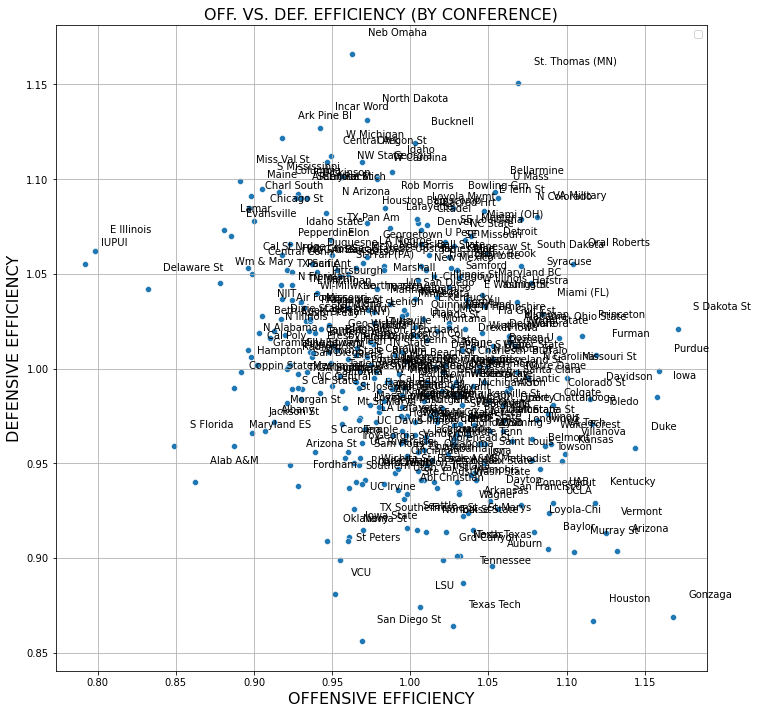

In [ ]:
# SCATTERPLOT - 
plt.figure(figsize=(10,10))
sns.scatterplot(data=tr_data_hub, x='offensive-efficiency', y='defensive-efficiency', palette='magma', markers=True)
plt.title('OFF. VS. DEF. EFFICIENCY (BY CONFERENCE)', fontsize=16)
plt.xlabel('OFFENSIVE EFFICIENCY', fontsize=16)
plt.ylabel('DEFENSIVE EFFICIENCY', fontsize=16)
plt.legend(loc='best')

plt.grid()
plt.tight_layout(pad=1)

for i in tr_data_hub.index:
  plt.text(tr_data_hub['offensive-efficiency'][tr_data_hub.index==i]+.01,tr_data_hub['defensive-efficiency'][tr_data_hub.index==i]+.01,str(i), color='black')

plt.show()

In [ ]:
tr_data_hub.columns

Index(['points-per-game', 'average-scoring-margin',
       'field-goals-made-per-game', 'field-goals-attempted-per-game',
       'offensive-efficiency', 'defensive-efficiency',
       'effective-field-goal-pct', 'true-shooting-percentage',
       'three-point-pct', 'two-point-pct', 'free-throw-pct',
       'three-pointers-made-per-game', 'three-pointers-attempted-per-game',
       'offensive-rebounds-per-game', 'defensive-rebounds-per-game',
       'total-rebounds-per-game', 'offensive-rebounding-pct',
       'defensive-rebounding-pct', 'total-rebounding-percentage',
       'blocks-per-game', 'steals-per-game', 'assists-per-game',
       'turnovers-per-game', 'assist--per--turnover-ratio',
       'win-pct-all-games', 'win-pct-close-games', 'possessions-per-game',
       'personal-fouls-per-game', 'opponent-points-per-game',
       'opponent-average-scoring-margin', 'opponent-shooting-pct',
       'opponent-effective-field-goal-pct', 'opponent-three-point-pct',
       'opponent-two-poin

In [ ]:
# create correlation variables relative to rest of DataFrame
win_pct_all_corr = tr_data_hub.corr()[['win-pct-all-games']].sort_values(by = 'Rank', ascending = False)
win_pct_close_corr = tr_data_hub.corr()[['win-pct-close-games']].sort_values(by = 'Seed', ascending = False)

# create heatmap to visualize correlation variable
  # SUBPLOTS
plt.figure(figsize=(10,8))
sns.heatmap(rank_corr, annot = True, cmap = 'flare', vmin=-1, vmax=1, linecolor = 'white', linewidth = 2);
#sns.heatmap(seed_corr, annot = True, cmap = 'flare', vmin=-1, vmax=1, linecolor = 'white', linewidth = 2);

KeyError: ignored

# KAGGLE CHALLENGE

## IMPORTS

In [ ]:
## LIBRARY IMPORTS

import sys
#from google.colab import drive

import numpy as np
import pandas as pd

%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')


random_seed = 42
tf.random.set_seed(random_seed)
#import numpy as np
np.random.seed(random_seed)


In [ ]:
# Absolute path of current folder
abspath_curr = '/content/drive/My Drive/SPORTS/NCAAB/'

# Absolute path of shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/spring_2022/code/utilities/p2_shallow_learning/'

In [ ]:
# IMPORT 

#tourney_detail = pd.read_csv('drive/My Drive/SPORTS/NCAAB/data/MNCAATourneyDetailedResults.csv')
reg_szn_detail = pd.read_csv('drive/My Drive/SPORTS/NCAAB/data/MRegularSeasonDetailedResults.csv')

#print(tourney_detail.head())
#print('-'*100)
#print(tourney_detail.info())
print('-'*100)
print(reg_szn_detail.head())
print('-'*100)
#print(reg_szn_detail.info())

----------------------------------------------------------------------------------------------------
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]
-----

## FEATURE ENGINEERING

In [ ]:
## COLUMN RENAME
reg_szn_rename = {
    'WTeamID':'ATeamID',
     'LTeamID':'BTeamID',
     'WScore':'AScore',
     'LScore':'BScore',
     'WFGM':'AFGM',
     'LFGM':'BFGM',
     'WFGA':'AFGA',
     'LFGA':'BFGA', 
     'WFGM3':'AFGM3',
     'LFGM3':'BFGM3',
     'WFGA3':'AFGA3',
     'LFGA3':'BFGA3',
     'WFTM':'AFTM',
     'LFTM':'BFTM', 
     'WFTA':'AFTA',
     'LFTA':'BFTA',
     'WOR':'AOR',
     'LOR':'BOR',
     'WDR':'ADR',
     'LDR':'BDR',
     'WAst':'AAst',
     'LAst':'BAst',
     'WTO':'ATO',
     'LTO':'BTO',
     'WStl':'AStl',
     'LStl':'BStl', 
     'WBlk':'ABlk',
     'LBlk':'BBlk',
     'WPF':'APF',
     'LPF':'BPF',
     'WLoc':'ALoc',
}

reg_szn_detail = reg_szn_detail.rename(columns=reg_szn_rename)
reg_szn_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100423 entries, 0 to 100422
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   100423 non-null  int64 
 1   DayNum   100423 non-null  int64 
 2   ATeamID  100423 non-null  int64 
 3   AScore   100423 non-null  int64 
 4   BTeamID  100423 non-null  int64 
 5   BScore   100423 non-null  int64 
 6   ALoc     100423 non-null  object
 7   NumOT    100423 non-null  int64 
 8   AFGM     100423 non-null  int64 
 9   AFGA     100423 non-null  int64 
 10  AFGM3    100423 non-null  int64 
 11  AFGA3    100423 non-null  int64 
 12  AFTM     100423 non-null  int64 
 13  AFTA     100423 non-null  int64 
 14  AOR      100423 non-null  int64 
 15  ADR      100423 non-null  int64 
 16  AAst     100423 non-null  int64 
 17  ATO      100423 non-null  int64 
 18  AStl     100423 non-null  int64 
 19  ABlk     100423 non-null  int64 
 20  APF      100423 non-null  int64 
 21  BFGM     1

In [ ]:
reg_szn_detail['TeamID'] = reg_szn_detail['ATeamID']

reg_szn_detail['AMargin'] = reg_szn_detail['AScore'] - reg_szn_detail['BScore']
reg_szn_detail['BMargin'] = reg_szn_detail['BScore'] - reg_szn_detail['AScore']

WCount = reg_szn_detail.groupby(['Season', 'ATeamID']).count()
WCount = WCount.reset_index()[['Season', 'ATeamID', 'DayNum']].rename(columns={"DayNum": "WCount", "ATeamID": "TeamID"})
LCount = reg_szn_detail.groupby(['Season', 'BTeamID']).count()
LCount = LCount.reset_index()[['Season', 'BTeamID', 'DayNum']].rename(columns={"DayNum": "LCount", "BTeamID": "TeamID"})

AMargin = reg_szn_detail.groupby(['Season', 'ATeamID']).mean().reset_index()
AMargin = AMargin[['Season', 'ATeamID', 'AMargin']].rename(columns={"WMargin": "WMargin", "ATeamID": "TeamID", 'AMargin': 'AMarginAvg'})
BMargin = reg_szn_detail.groupby(['Season', 'BTeamID']).mean().reset_index()
BMargin = BMargin[['Season', 'BTeamID', 'BMargin']].rename(columns={"LMargin": "LMargin", "BTeamID": "TeamID", 'BMargin': 'BMarginAvg'})


#reg_szn_detail.head()
#reg_szn_detail[:60]
reg_szn_detail.info()
#reg_szn_AB['AMarginAvg'][:50]
#margin_df.head()
#WCount.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100423 entries, 0 to 100422
Data columns (total 37 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   100423 non-null  int64 
 1   DayNum   100423 non-null  int64 
 2   ATeamID  100423 non-null  int64 
 3   AScore   100423 non-null  int64 
 4   BTeamID  100423 non-null  int64 
 5   BScore   100423 non-null  int64 
 6   ALoc     100423 non-null  object
 7   NumOT    100423 non-null  int64 
 8   AFGM     100423 non-null  int64 
 9   AFGA     100423 non-null  int64 
 10  AFGM3    100423 non-null  int64 
 11  AFGA3    100423 non-null  int64 
 12  AFTM     100423 non-null  int64 
 13  AFTA     100423 non-null  int64 
 14  AOR      100423 non-null  int64 
 15  ADR      100423 non-null  int64 
 16  AAst     100423 non-null  int64 
 17  ATO      100423 non-null  int64 
 18  AStl     100423 non-null  int64 
 19  ABlk     100423 non-null  int64 
 20  APF      100423 non-null  int64 
 21  BFGM     1

In [ ]:
reg_szn_Margin = pd.merge(AMargin, BMargin, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='inner')
reg_szn_WLCount = pd.merge(WCount, LCount, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='inner')
reg_szn_WL_margin = pd.merge(reg_szn_WLCount, reg_szn_Margin, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='inner')
reg_szn_detail = pd.merge(reg_szn_detail, reg_szn_WL_margin, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='inner')

reg_szn_detail['WRatio'] = (reg_szn_detail.WCount / (reg_szn_detail.WCount + reg_szn_detail.LCount))

reg_szn_detail['WtdAvgMargin'] = ((reg_szn_detail['WCount'] * reg_szn_detail['AMarginAvg'] -
                                reg_szn_detail['LCount'] * reg_szn_detail['BMarginAvg']) /
                               (reg_szn_detail['WCount'] + reg_szn_detail['LCount'])
                               )
reg_szn_detail.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100330 entries, 0 to 100329
Data columns (total 43 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Season        100330 non-null  int64  
 1   DayNum        100330 non-null  int64  
 2   ATeamID       100330 non-null  int64  
 3   AScore        100330 non-null  int64  
 4   BTeamID       100330 non-null  int64  
 5   BScore        100330 non-null  int64  
 6   ALoc          100330 non-null  object 
 7   NumOT         100330 non-null  int64  
 8   AFGM          100330 non-null  int64  
 9   AFGA          100330 non-null  int64  
 10  AFGM3         100330 non-null  int64  
 11  AFGA3         100330 non-null  int64  
 12  AFTM          100330 non-null  int64  
 13  AFTA          100330 non-null  int64  
 14  AOR           100330 non-null  int64  
 15  ADR           100330 non-null  int64  
 16  AAst          100330 non-null  int64  
 17  ATO           100330 non-null  int64  
 18  AStl

## TARGET

In [ ]:
# GENERATE COLUMNS FOR TARGET VARIABLE PREDICTION

reg_szn_detail['ScoreMargin'] = reg_szn_detail['AScore'] - reg_szn_detail['BScore']
reg_szn_detail['Win'] = (reg_szn_detail['ScoreMargin'] > 0).astype(int)

In [ ]:
# DROP COLUMNS
reg_szn_detail.drop(['NumOT', 'ALoc', 'WCount', 'LCount', 'AMargin', 'BMargin', 'ATeamID', 'BTeamID', 'TeamID', 'DayNum', 'Season'], axis=1, inplace=True)
reg_szn_detail.info()

## TRAIN-TEST

In [ ]:
# DEFINE TEST FEATURES
test_features = ['ScoreMargin',
                 'Win',
                 'AFGM',
     'BFGM',
     'AFGA',
     'BFGA', 
     'AFGM3',
     'BFGM3',
     'AFGA3',
     'BFGA3',
     'AFTM',
     'BFTM', 
     'AFTA',
     'BFTA',
    'AOR',
    'BOR',
    'ADR',
    'BDR',
     'AAst',
     'BAst',
     'ATO',
     'BTO',
     'AStl',
     'BStl', 
     'ABlk',
     'BBlk',
     'APF',
     'BPF',
     'WtdAvgMargin',
     'WRatio',
]

reg_szn_test = reg_szn_detail[test_features]
reg_szn_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100330 entries, 0 to 100329
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ScoreMargin   100330 non-null  int64  
 1   Win           100330 non-null  int64  
 2   AFGM          100330 non-null  int64  
 3   BFGM          100330 non-null  int64  
 4   AFGA          100330 non-null  int64  
 5   BFGA          100330 non-null  int64  
 6   AFGM3         100330 non-null  int64  
 7   BFGM3         100330 non-null  int64  
 8   AFGA3         100330 non-null  int64  
 9   BFGA3         100330 non-null  int64  
 10  AFTM          100330 non-null  int64  
 11  BFTM          100330 non-null  int64  
 12  AFTA          100330 non-null  int64  
 13  BFTA          100330 non-null  int64  
 14  AOR           100330 non-null  int64  
 15  BOR           100330 non-null  int64  
 16  ADR           100330 non-null  int64  
 17  BDR           100330 non-null  int64  
 18  AAst

In [ ]:
reg_szn_test.head()

,ScoreMargin,Win,AFGM,BFGM,AFGA,BFGA,AFGM3,BFGM3,AFGA3,BFGA3,...,ATO,BTO,AStl,BStl,ABlk,BBlk,APF,BPF,WtdAvgMargin,WRatio
0,6,1,27,22,58,53,3,2,14,10,...,23,18,7,9,1,2,22,20,11.714286,0.607143
1,26,1,24,19,49,55,10,8,20,21,...,13,15,7,6,3,2,14,22,11.714286,0.607143
2,15,1,27,25,59,66,8,7,24,23,...,13,21,10,6,6,2,13,20,11.714286,0.607143
3,6,1,16,16,57,50,7,2,25,6,...,13,13,6,3,6,5,21,19,11.714286,0.607143
4,28,1,34,23,70,61,9,7,22,18,...,10,13,10,2,4,3,17,15,11.714286,0.607143


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reg_szn_test, train_size=0.8, random_state=42)

# Load the raw training data
df_raw_train = train

# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)

# Load the raw test data
df_raw_test = test

# Make a copy of df_raw_test
df_test = df_raw_test.copy(deep=True)

In [ ]:
## TARGET VARIABLE ASSIGNMENT

target = 'Win'

In [ ]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,80264,30


In [ ]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,20066,30


In [ ]:
# Print the first 5 rows of df_train
df_train.head()

,ScoreMargin,Win,AFGM,BFGM,AFGA,BFGA,AFGM3,BFGM3,AFGA3,BFGA3,...,ATO,BTO,AStl,BStl,ABlk,BBlk,APF,BPF,WtdAvgMargin,WRatio
63579,17,1,24,23,49,54,7,5,13,14,...,11,10,4,5,0,5,10,19,10.464286,0.571429
46173,3,1,25,21,54,47,3,6,14,13,...,8,6,2,4,4,1,19,22,9.677419,0.516129
1744,20,1,29,23,59,59,9,7,19,25,...,14,14,10,6,8,2,19,20,13.464286,0.500000
59987,15,1,25,21,58,55,6,4,19,17,...,12,12,5,7,6,4,22,25,11.642857,0.642857
63384,6,1,28,26,57,65,5,5,13,23,...,10,9,3,1,2,1,19,28,11.896552,0.655172


In [ ]:
# Print the first 5 rows of df_test
df_test.head()

,ScoreMargin,Win,AFGM,BFGM,AFGA,BFGA,AFGM3,BFGM3,AFGA3,BFGA3,...,ATO,BTO,AStl,BStl,ABlk,BBlk,APF,BPF,WtdAvgMargin,WRatio
5219,8,1,17,25,64,69,3,7,17,20,...,17,16,8,8,7,8,20,33,9.933333,0.500000
18086,6,1,27,24,53,63,8,8,14,31,...,17,20,11,6,3,2,20,20,9.464286,0.321429
34858,12,1,23,18,65,56,7,2,21,14,...,13,11,6,7,3,5,21,20,10.466667,0.433333
41527,15,1,22,25,59,77,8,4,26,22,...,7,11,7,4,3,4,14,26,12.593750,0.468750
53342,1,1,16,16,42,46,2,3,11,15,...,14,9,3,8,6,4,12,8,8.870968,0.548387


## SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

In [ ]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,64211,30


In [ ]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,16053,30


In [ ]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)
df.head()

,ScoreMargin,Win,AFGM,BFGM,AFGA,BFGA,AFGM3,BFGM3,AFGA3,BFGA3,...,ATO,BTO,AStl,BStl,ABlk,BBlk,APF,BPF,WtdAvgMargin,WRatio
0,6,1,23,25,48,54,6,7,16,20,...,7,10,6,7,1,3,11,19,11.451613,0.709677
1,3,1,34,31,62,57,11,13,22,27,...,10,13,7,7,2,4,19,16,11.290323,0.709677
2,7,1,22,19,47,44,4,1,15,10,...,15,16,8,7,4,6,16,16,12.600000,0.400000
3,1,1,33,30,76,74,12,10,36,27,...,9,5,4,6,8,5,15,13,13.200000,0.800000
4,16,1,28,21,64,55,9,5,28,24,...,10,14,9,4,0,5,18,16,12.150000,0.500000


## LABEL ENCODER

In [ ]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target])

# Print the first 5 rows of df
df.head()

,ScoreMargin,Win,AFGM,BFGM,AFGA,BFGA,AFGM3,BFGM3,AFGA3,BFGA3,...,ATO,BTO,AStl,BStl,ABlk,BBlk,APF,BPF,WtdAvgMargin,WRatio
0,6,0,23,25,48,54,6,7,16,20,...,7,10,6,7,1,3,11,19,11.451613,0.709677
1,3,0,34,31,62,57,11,13,22,27,...,10,13,7,7,2,4,19,16,11.290323,0.709677
2,7,0,22,19,47,44,4,1,15,10,...,15,16,8,7,4,6,16,16,12.600000,0.400000
3,1,0,33,30,76,74,12,10,36,27,...,9,5,4,6,8,5,15,13,13.200000,0.800000
4,16,0,28,21,64,55,9,5,28,24,...,10,14,9,4,0,5,18,16,12.150000,0.500000


## PRE-PROCESSING

In [ ]:
#df.drop(['id'], inplace=True,  axis=1)
#df.head()

In [ ]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [ ]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,64211,30


In [ ]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,16053,30


In [ ]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,20066,30


In [ ]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

## FEATURE MATRIX

In [ ]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

## SCALE

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler
mms = MinMaxScaler()

In [ ]:
# Normalize the training data
X_train = mms.fit_transform(X_train)

# Normalize the validation data
X_val = mms.transform(X_val)

# Normalize the test data
X_test = mms.transform(X_test)

# HYPERPARAMETER TUNING

In [ ]:
# Model / Package Imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingClassifier

# Creating dictionary of the models
models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          #'hgbc': HistGradientBoostingClassifier(random_state=random_seed)
          }

In [ ]:
# Creating the dictionary of the pipelines
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
## SUPPLEMENTAL - NOT NECESSARY

# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/spring_2022/code/utilities/p2_shallow_learning


In [ ]:
#Getting the predefined split cross-validator
  # feature matrix and target velctor in the combined training and validation data
  # target vector in the combined training and validation data
  # PredefinedSplit
  # See the implementation in pmlm_utilities.ipynb

X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

## GridSearch CV Param Grids

In [ ]:
param_grids = {}

## Logistic Regression

In [ ]:
# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -3] #10 ** -11, 
  # ORIGINAL: tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [10, 1, .1, 0.01] # 1 , .001
  # ORIGINAL: C_grid = [0.1, 1, 10]

# The parameter grid of penalty type
penalty_grid = ['none', 'l1', 'l2'] #, 'elasticnet'

# The parameter grid of solver type
solver_grid = ['newton-cg', 'lbfgs', 'liblinear'] # 'sag', 'saga'

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid,
                      #'model__penalty': penalty_grid,
                      'model__solver': solver_grid,
                      }]

## MLP Classifier

In [ ]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]
  # ORIGINAL: alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [9 ** i for i in range(-3, -1)]
  # ORIGINAL: learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

## Random Forest Classifier

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [20, 100]
  # ORIGINAL: min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 100]
  # ORIGINAL: min_samples_leaf_grids = [1, 20, 100]

# The grids for n_estimators
n_estimators_grids = [100] # 10, 50, 100

# The grids for max_depth
max_depth_grids = [1, 5, 10]

# The grids for max_features
max_features_grids = ['auto', 'sqrt']

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__n_estimators': n_estimators_grids,
                       #'model__max_depth': max_depth_grids,
                       #'model__max_features': max_features_grids,
                       }]

                       # model__max_depth: 

## GRIDSEARCH

In [ ]:
import os
# Make directory
directory = os.path.dirname(abspath_curr + '/result/mm2022/GridSearchCV_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# HYPERPARAMETER TUNING

from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2, #8
                      cv=ps, #5
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr + '/result/mm2022/GridSearchCV_results/' + acronym + '.csv', index=False) #'/result/mnist/cv_results/GridSearchCV/'

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

ValueError: ignored

## MODEL SELECTION

In [ ]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

In [ ]:
print(best_score_gs)
print(best_params_gs)
print(best_estimator_gs)

0.2633100340428174
{'model__alpha': 0.001, 'model__learning_rate_init': 0.012345679012345678}
Pipeline(steps=[('model',
                 MLPClassifier(alpha=0.001, early_stopping=True,
                               learning_rate_init=0.012345679012345678,
                               random_state=42))])


# GENERATE SUBMISSION FILE
###### Use best model as selected above to generate submission file for Kaggle competition:

## Create Directory

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Generate Submission

In [ ]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((np.arange(1, y_test_pred.shape[0] + 1).reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['id', target]).astype({'id':int, target:int})                                                                                      

# Generate the submission file
df_submit.to_csv(abspath_curr + '/result/submission/submission.csv', index=False)                                                                              

# INTERPRETATION

## Create Directory

In [ ]:
import os

# Make directory
directory = os.path.dirname(abspath_curr + '/result/poker/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Feature Importance - Table

In [ ]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[1]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc[:]

## Feature Importance - Plot

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/poker/figure/feature_importance_rfc.pdf')
plt.show()

# SCRATCH NOTES

## PCA

In [ ]:
#%%

X = df[features].values
X = StandardScaler().fit_transform(X)

#%%
pca = PCA(n_components='mle', svd_solver='full') # 'mle'

pca.fit(X)
X_PCA = pca.transform(X)
print('ORIGINAL DIMENSIONS:', X.shape)
print('TRANSFORMED DIMENSIONS:', X_PCA.shape)
print(f'EXPLAINED VARIANCE RATIO: {pca.explained_variance_ratio_}')

#%%
x = np.arange(1, len(np.cumsum(pca.explained_variance_ratio_))+1, 1)

plt.figure(figsize=(12,8))
plt.plot(x, np.cumsum(pca.explained_variance_ratio_))
plt.xticks(x)

plt.show()


## SVD

In [ ]:
# SINGULAR VALUE DECOMPOSITION ANALYSIS [SVD]
# CONDITION NUMBER

# ORIGINAL DATA

from numpy import linalg as LA

H = np.matmul(X.T, X)
_, d, _ = np.linalg.svd(H)
print(f'ORIGINAL DATA: SINGULAR VALUES {d}')
print(f'ORIGINAL DATA: CONDITIONAL NUMBER {LA.cond(X)}')

In [ ]:
# TRANSFORMED DATA
H_PCA = np.matmul(X_PCA.T, X_PCA)
_, d_PCA, _ = np.linalg.svd(H_PCA)
print(f'TRANSFORMED DATA: SINGULAR VALUES {d_PCA}')
print(f'TRANSFORMED DATA: CONDITIONAL NUMBER {LA.cond(X_PCA)}')
print('*'*58)

#%%
# CONSTRUCTION OF REDUCED DIMENSION DATASET

#pca_df = pca.explained_variance_ratio_

a, b = X_PCA.shape
column = []

for i in range(b):
    column.append(f'PRINCIPAL COLUMN {i+1}')

df_PCA = pd.DataFrame(data=X_PCA, columns=column)
df_PCA = pd.concat([df_PCA, Y], axis=1)

df_PCA.info()